In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from datetime import timedelta
import seaborn as sns
import mplfinance as mpf

1. Análisis exploratorio.

In [3]:
df = pd.read_excel("C:/Users/John/Downloads/GBPJPY Price history Df overall.xlsx")

In [4]:
df['Date'] = pd.to_datetime(df['Date'])       #Asegura formato datetime
df.set_index('Date', inplace=True)

In [5]:
print("Columns in your DataFrame:") 
print(df.columns.tolist())

Columns in your DataFrame:
['Open', 'High', 'Low', 'Close']


In [6]:
print(df.index)

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-06',
               '2020-01-07', '2020-01-08', '2020-01-09', '2020-01-10',
               '2020-01-13', '2020-01-14',
               ...
               '2025-07-29', '2025-07-30', '2025-07-31', '2025-08-01',
               '2025-08-03', '2025-08-04', '2025-08-05', '2025-08-06',
               '2025-08-07', '2025-08-08'],
              dtype='datetime64[ns]', name='Date', length=1465, freq=None)


In [7]:
print(df.index)  # Check if index is datetime

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-06',
               '2020-01-07', '2020-01-08', '2020-01-09', '2020-01-10',
               '2020-01-13', '2020-01-14',
               ...
               '2025-07-29', '2025-07-30', '2025-07-31', '2025-08-01',
               '2025-08-03', '2025-08-04', '2025-08-05', '2025-08-06',
               '2025-08-07', '2025-08-08'],
              dtype='datetime64[ns]', name='Date', length=1465, freq=None)


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1465 entries, 2020-01-01 to 2025-08-08
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1465 non-null   float64
 1   High    1465 non-null   float64
 2   Low     1465 non-null   float64
 3   Close   1465 non-null   float64
dtypes: float64(4)
memory usage: 57.2 KB


In [9]:
df.head()

,Open,High,Low,Close
Date,,,,
2020-01-01,144.05,144.24,143.79,144.07
2020-01-02,144.09,144.20,142.26,142.68
2020-01-03,142.73,142.81,140.99,141.43
2020-01-06,141.31,142.81,140.84,142.68
2020-01-07,142.71,143.31,142.01,142.25


In [10]:
df.tail()

,Open,High,Low,Close
Date,,,,
2025-08-04,195.68,196.58,195.00,195.41
2025-08-05,195.50,196.51,195.01,196.33
2025-08-06,196.33,197.11,196.06,196.83
2025-08-07,196.84,198.07,196.22,197.78
2025-08-08,197.78,198.87,197.36,198.70


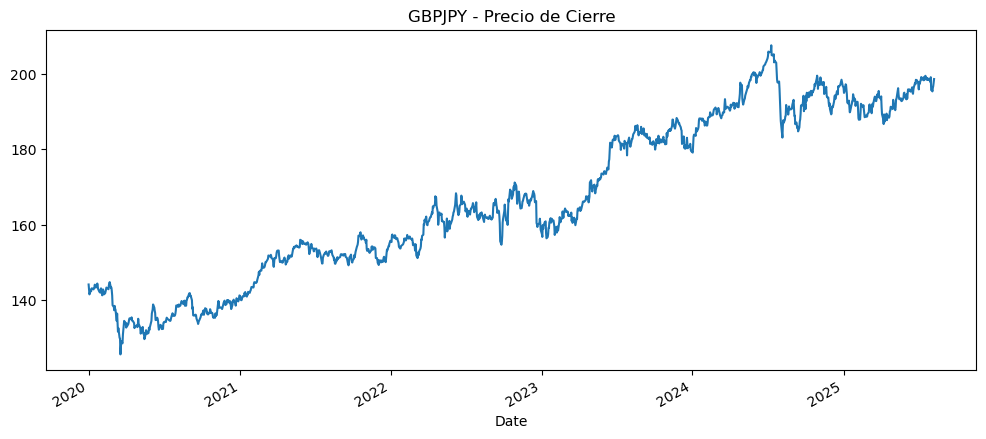

In [11]:
df["Close"].plot(title="GBPJPY - Precio de Cierre", figsize=(12,5))
plt.show()

Paso 2. Inspección visual: Tendencia y estacionalidad

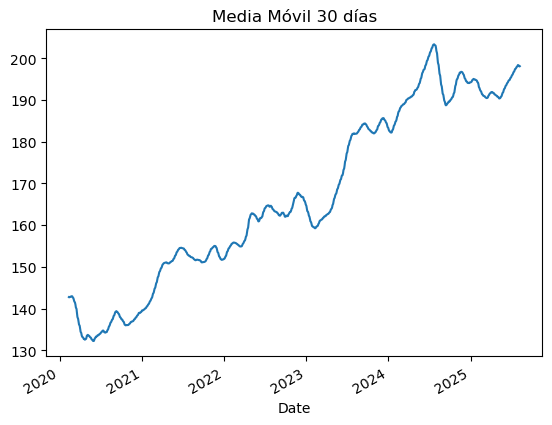

In [12]:
df['Close'].rolling(window=30).mean().plot(title='Media Móvil 30 días')
plt.show()

Paso 3: Transformación a log-retornos.

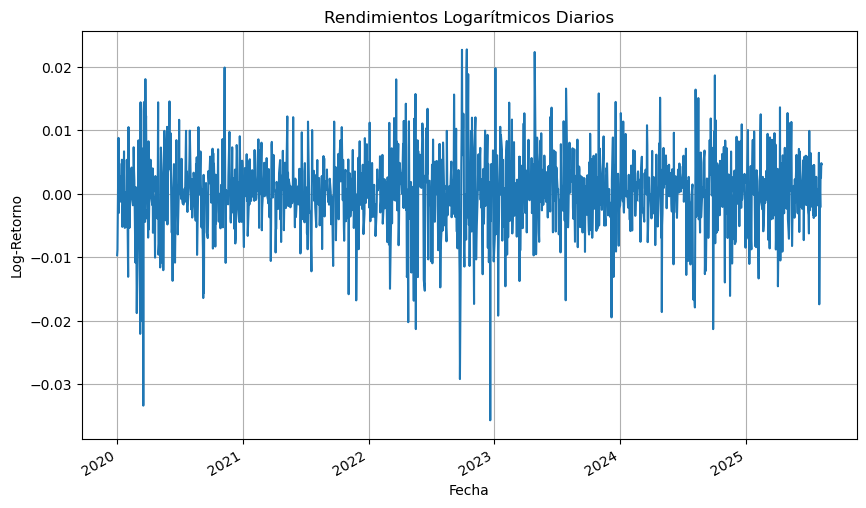

In [14]:
df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
df["log_return"].dropna().plot(title="Rendimientos Logarítmicos Diarios", figsize=(10, 6))
plt.xlabel("Fecha")
plt.ylabel("Log-Retorno")
plt.grid(True)
plt.show()

In [15]:
import numpy as np

Paso 4 : Prueba de estacionaridad - ADF Test

In [16]:
result = adfuller(df["log_return"].dropna())
print(f"ADF Statistic: {result [0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -37.20829527561879
p-value: 0.0


ADF STATISTICS : ES MUY NEGATIVA, INDICANDO FUERTE EVIDENCIA CONTRA LA HIPÓTESIS NULA. P-VALUE: ? Conclusión: La serie de log-retornos es estacionaria, por lo tanto: no es necesario diferenciar. Podemos trabajar directamente con esta serie para ARIMA Y GARCH.

Paso 5 _ ACF Y PACF para identificar estructura ARIMA

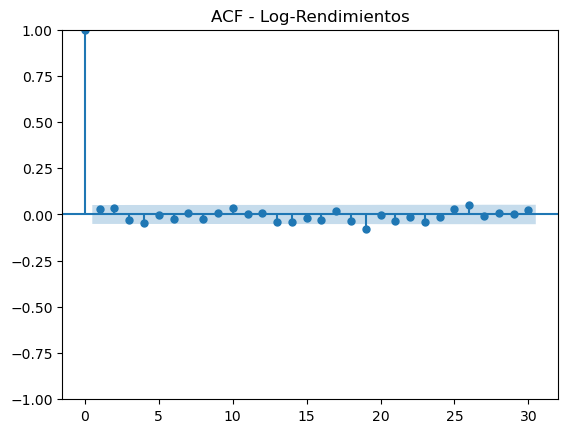

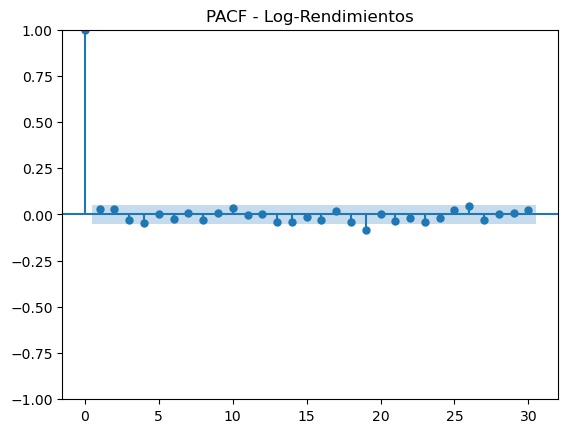

In [17]:
plot_acf(df['log_return'].dropna(),lags=30)
plt.title("ACF - Log-Rendimientos")
plt.show()

plot_pacf(df['log_return'].dropna(), lags=30)
plt.title("PACF - Log-Rendimientos")
plt.show()

El comportamiento es característico de una serie de retornos financieros, donde el modelo ARIMA no aporta mucho en la media, y el foco suele estar en modelar la volatilidad (GARCH)

In [18]:
model_arima = ARIMA(df['log_return'].dropna(), order=(1, 0, 1))
result_arima = model_arima.fit()
print(result_arima.summary())

C:\Users\John\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\John\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\John\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             log_return   No. Observations:                 1464
Model:                 ARIMA(1, 0, 1)   Log Likelihood                5357.771
Date:                Sun, 10 Aug 2025   AIC                         -10707.543
Time:                        02:10:17   BIC                         -10686.387
Sample:                             0   HQIC                        -10699.652
                               - 1464                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      1.255      0.209      -0.000       0.001
ar.L1         -0.0454      0.788     -0.058      0.954      -1.590       1.499
ma.L1          0.0730      0.785      0.093      0.9

PASO 6: Modelar GARCH

In [19]:
garch_model = arch_model(df['log_return'].dropna(), vol='GARCH', p=1, q=1, mean='ARX', lags=1)
garch_result = garch_model.fit(disp='off')
print(garch_result.summary())

                           AR - GARCH Model Results                           
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:                5420.54
Distribution:                  Normal   AIC:                          -10831.1
Method:            Maximum Likelihood   BIC:                          -10804.6
                                        No. Observations:                 1463
Date:                Sun, Aug 10 2025   Df Residuals:                     1461
Time:                        02:11:54   Df Model:                            2
                                   Mean Model                                  
                    coef    std err          t      P>|t|      95.0% Conf. Int.
-------------------------------------------------------------------------------
Const         3.4965e-04  1.429e-04      2.447  1

C:\Users\John\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.875e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


PASO 7: FORECAST a 1 año (252 días hábiles)

In [20]:
#Forecast 252 días hacia adelante 1 año de trading)
forecast_horizon= 252
forecast = garch_result.forecast (horizon=forecast_horizon)

#Extraemos las trayectorias completas (última fila el forecast futuro desde hoy)
mean_forecast = forecast.mean.iloc[-1].values
variance_forecast = forecast.variance.iloc[-1].values
vol_forecast = np.sqrt(variance_forecast)

# Impresiones correctas
print(f"Primera media forecast: {mean_forecast[0]:.6f}")
print(f"Última media forecast: {mean_forecast[-1]:.6f}")
print(f"Primera desviación estándar forecast: {vol_forecast[0]:.6f}")
print(f"Última desviación estándar forecast: {vol_forecast[-1]:6f}")

Primera media forecast: 0.000478
Última media forecast: 0.000360
Primera desviación estándar forecast: 0.005813
Última desviación estándar forecast: 0.006227


Paso 8: Graficar los precios con una banda de confianza del 95% estamos modelando la volatilidad Eventos macroeconomicos (Guerra,Pandemia,FED)

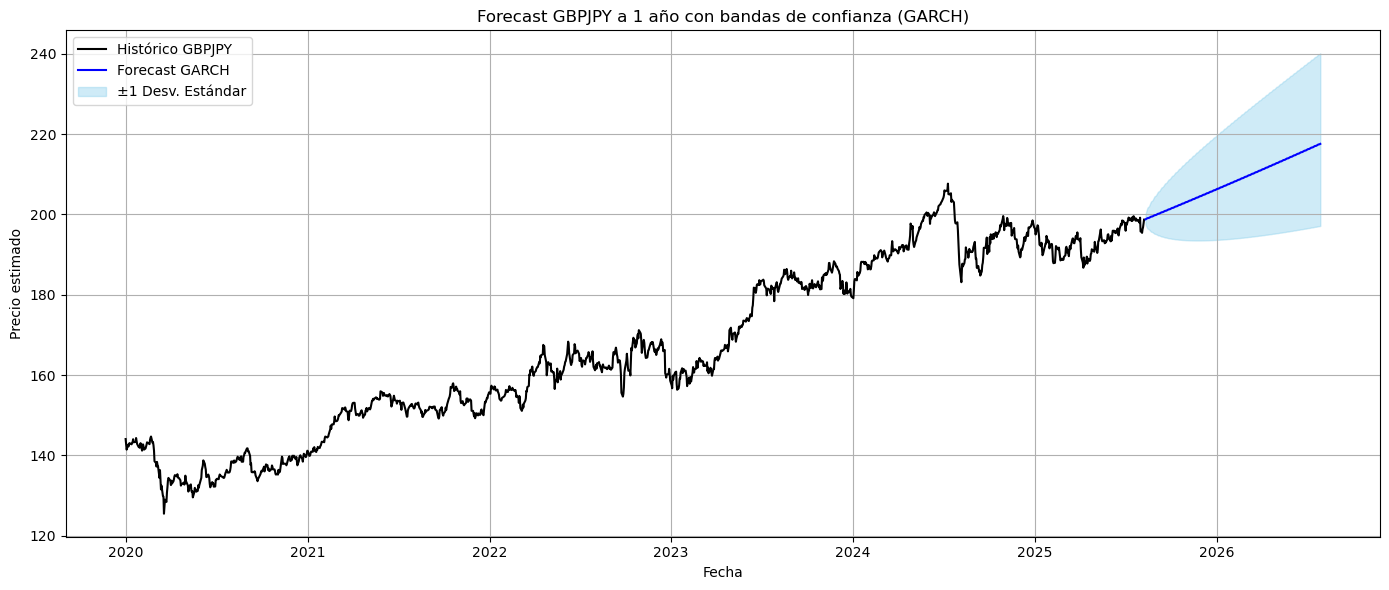

In [21]:
#Supone que tienes df{'GBPJPY'} como serie histórico de precios
last_price = df['Close'].iloc[-1]

#1. Cálculo acumulado 
cum_mean= np.cumsum(mean_forecast)
cum_std= np.sqrt(np.cumsum(vol_forecast**2))

#2. Forecast de precios y bandas 
expected_price = last_price * np.exp(cum_mean)
upper_band = last_price * np.exp(cum_mean + cum_std)
lower_band = last_price * np.exp(cum_mean - cum_std)

#3. Fecha futuras
future_dates = pd. date_range(start=df.index[-1], periods=forecast_horizon + 1, freq='B')[1:]

#4. Gráfico
plt.figure(figsize=(14,6))

# Historial
plt.plot(df.index, df['Close'], label='Histórico GBPJPY', color='black')

# Forecast
plt.plot(future_dates, expected_price, label='Forecast GARCH', color ='blue')

# bandas de confianza ±1
plt.fill_between(future_dates, lower_band, upper_band, color='skyblue', alpha=0.4, label='±1 Desv. Estándar')

# Detalles
plt.title("Forecast GBPJPY a 1 año con bandas de confianza (GARCH)")
plt.xlabel("Fecha")
plt.ylabel("Precio estimado")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()